# Credit Card Fraud Detection using CNN (Anomaly Detection)

이 노트북은 신용 카드 사기 탐지를 위한 컨볼루션 신경망(CNN) 모델을 구현합니다.
**정상 거래 데이터만을 사용하여 학습**하는 이상탐지(Anomaly Detection) 접근법을 사용하며, 
오토인코더 구조 없이 CNN 본연의 구조만을 활용합니다.

## CNN 이상탐지 구조 개요

이 CNN 모델은 다음과 같은 특징을 가집니다:

1. **정상 데이터만 학습**: 사기 거래 없이 정상 거래 패턴만을 학습하여 이상치를 탐지합니다.
2. **1D 컨볼루션**: 거래 특성을 1D 시퀀스로 처리하여 패턴을 추출합니다.
3. **정상도 점수**: 모델은 각 거래에 대해 0~1 사이의 정상도 점수를 출력합니다.
4. **이상치 탐지**: 정상도 점수가 낮을수록 사기 거래일 가능성이 높습니다.

### 모델 구조:
- **Conv1D 레이어들**: 거래 패턴의 특성을 추출
- **MaxPooling1D**: 중요한 특성만 선별하여 차원 축소
- **Dropout**: 과적합 방지
- **Dense 레이어들**: 정상 거래의 특성 표현 학습
- **Sigmoid 출력**: 정상 거래와의 유사도를 0~1로 출력

이 접근법은 실제 환경에서 사기 거래 데이터가 부족하거나 새로운 사기 패턴이 등장할 때 효과적입니다.

In [1]:
# Core libraries for data processing and machine learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
from sklearn.decomposition import PCA
import time
import warnings

# Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

# 불필요한 경고 무시
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

c:\ProgramData\anaconda3\envs\my312\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Libraries imported successfully!


In [2]:
# ==========================================
# Data Loading and Preprocessing Pipeline
# ==========================================

# Load preprocessed credit card fraud dataset
df = pd.read_csv("preprocessed-creditcard.csv")
X = df.drop("Class", axis=1).values  # Feature matrix
y = df["Class"].values                # Target labels (0: normal, 1: fraud)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Fraud rate: {np.mean(y):.4f} ({np.sum(y)} fraud cases)")

# Stratified train-test split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ====== ANOMALY DETECTION APPROACH ======
# Extract only normal transactions for training 
normal_mask = y_train == 0
X_train_normal = X_train[normal_mask]
print(f"Normal transactions for training: {X_train_normal.shape[0]} samples")

# Feature standardization using Z-score normalization (fit on normal data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)  # Fit only on normal data
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set (normal only): {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

# For CNN, we need to reshape the data to 3D format (samples, timesteps, features)
# We'll treat each feature as a 1D sequence (time series)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

print(f"Reshaped training data for CNN (normal only): {X_train_reshaped.shape}")
print(f"Reshaped test data for CNN: {X_test_reshaped.shape}")

Dataset loaded: 946 samples, 30 features
Fraud rate: 0.5000 (473 fraud cases)
Normal transactions for training: 378 samples

Training set (normal only): (378, 30)
Test set: (190, 30)
Reshaped training data for CNN (normal only): (378, 30, 1)
Reshaped test data for CNN: (190, 30, 1)


In [3]:
# ==========================================
# Configuration
# ==========================================

# TRAINING CONFIGURATION
TRAINING_CONFIG = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.001,     # Adam optimizer stepsize
    'validation_split': 0.1,    # 10% of training data for validation
    'patience': 5               # Early stopping patience
}

print(f"\nTraining Configuration: {TRAINING_CONFIG}")
print("="*80)


Training Configuration: {'epochs': 50, 'batch_size': 32, 'learning_rate': 0.001, 'validation_split': 0.1, 'patience': 5}


In [4]:
# ==========================================
# CNN Model Definition for Anomaly Detection
# ==========================================

def create_anomaly_detection_cnn(input_shape):
    """
    이상탐지를 위한 CNN 모델 생성 함수 (정상 데이터만 학습)
    
    Args:
        input_shape: 입력 데이터 형태 (features, 1)
        
    Returns:
        model: 컴파일된 Keras CNN 모델
    """
    model = Sequential([
        # 1D Convolution layers for feature extraction
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        
        # Flatten layer to convert 1D feature maps to a feature vector
        Flatten(),
        
        # Dense layers for feature representation learning
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        # Output layer: 정상 데이터에 대한 confidence score (0~1)
        # 높은 값 = 정상 거래와 유사, 낮은 값 = 이상 거래 (사기 가능성)
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model for anomaly detection
    # 정상 데이터에 대해 1에 가까운 값을 출력하도록 학습
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=TRAINING_CONFIG['learning_rate']),
        loss='binary_crossentropy',  # 정상 데이터는 레이블 1로 설정
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

In [5]:
def train_cnn_model():
    """
    정상 데이터만을 사용한 CNN 이상탐지 모델 학습 함수
    
    Returns:
        dict: 학습 결과와 모델을 포함한 딕셔너리
    """
    print(f"\n{'='*60}")
    print("TRAINING: CNN MODEL FOR ANOMALY DETECTION (NORMAL DATA ONLY)")
    print(f"{'='*60}")
    
    # 훈련 시작 시간 기록
    start_time = time.time()
    
    # 모델 생성
    input_shape = (X_train_scaled.shape[1], 1)
    model = create_anomaly_detection_cnn(input_shape)
    
    # 모델 요약 정보 출력
    model.summary()
    
    # 정상 데이터에 대한 레이블 생성 (모두 1로 설정 - 정상)
    y_train_normal = np.ones(X_train_reshaped.shape[0])
    
    # 조기 종료(Early Stopping) 콜백 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=TRAINING_CONFIG['patience'],
        restore_best_weights=True,
        verbose=1
    )
    
    # 모델 학습 (정상 데이터만 사용)
    history = model.fit(
        X_train_reshaped, 
        y_train_normal,  # 모든 정상 데이터에 대해 레이블 1
        epochs=TRAINING_CONFIG['epochs'],
        batch_size=TRAINING_CONFIG['batch_size'],
        validation_split=TRAINING_CONFIG['validation_split'],
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 훈련 종료 시간과 소요 시간 계산
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Trained on {X_train_reshaped.shape[0]} normal transactions only")
    
    return {
        'strategy': 'cnn_anomaly_detection',
        'model': model,
        'history': history,
        'training_time': training_time
    }

In [6]:
# 모델 학습
results = {}
try:
    cnn_result = train_cnn_model()
    results['cnn'] = cnn_result
    print(f"✓ CNN strategy completed successfully")
except Exception as e:
    print(f"✗ CNN strategy failed: {str(e)}")
    results['cnn'] = {'error': str(e)}


TRAINING: CNN MODEL FOR ANOMALY DETECTION (NORMAL DATA ONLY)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 15, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,625 (322.75 KB)

 Trainable params: 82,625 (322.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6677 - auc: 0.0000e+00 - loss: 0.5802 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0526
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.6677 - auc: 0.0000e+00 - loss: 0.5802 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0526
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0265 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 7.2988e-06
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0265 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 7.2988e-06
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 1.8356e-05 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 1.1249e-08
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 1.8356e-05 - val_accuracy: 1.0000 - val_auc: 0.0000e+

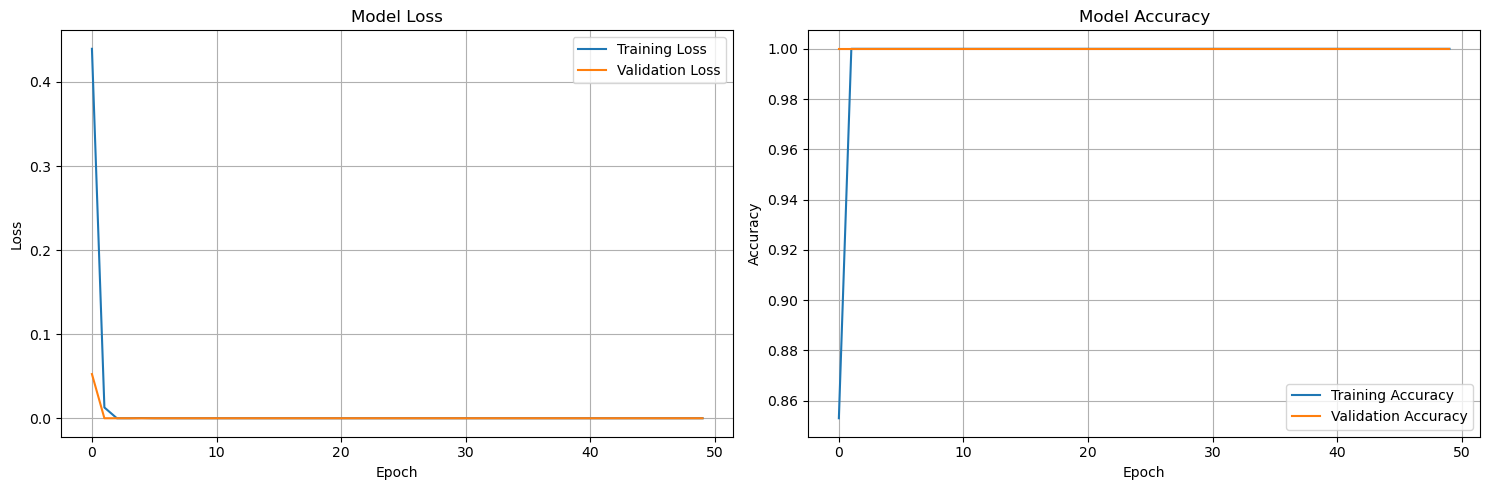

In [7]:
# 학습 과정 시각화
def plot_training_history(history):
    """
    모델 학습 과정을 시각화하는 함수
    
    Args:
        history: 모델 학습 결과 히스토리 객체
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss 그래프
    axes[0].plot(history.history['loss'], label='Training Loss')
    axes[0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0].set_title('Model Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # Accuracy 그래프
    axes[1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[1].set_title('Model Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 학습 과정 시각화 (학습이 성공적으로 완료된 경우)
if 'error' not in results['cnn']:
    plot_training_history(results['cnn']['history'])

In [8]:
# 모델 평가
def evaluate_anomaly_detection_model(model, X_test_data, y_test_data):
    """
    이상탐지 CNN 모델 평가 함수
    
    Args:
        model: 학습된 Keras CNN 모델
        X_test_data: 테스트 데이터
        y_test_data: 테스트 레이블 (0: 정상, 1: 사기)
        
    Returns:
        dict: 평가 지표들을 포함한 딕셔너리
    """
    # 정상도 점수 예측 (높을수록 정상 거래와 유사)
    normality_scores = model.predict(X_test_data).flatten()
    
    # 이상치 점수로 변환 (1 - normality_score)
    # 높을수록 사기 가능성이 높음
    anomaly_scores = 1 - normality_scores
    
    # 다양한 임계값에서의 성능 평가
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    results = []
    
    print("Threshold optimization (anomaly score >= threshold = fraud):")
    for threshold in thresholds:
        y_pred = (anomaly_scores >= threshold).astype(int)
        
        # 혼동 행렬 계산
        tn, fp, fn, tp = confusion_matrix(y_test_data, y_pred, labels=[0,1]).ravel()
        
        # 평가 지표 계산
        acc = accuracy_score(y_test_data, y_pred)
        prec = precision_score(y_test_data, y_pred, zero_division=0)
        rec = recall_score(y_test_data, y_pred, zero_division=0)
        f1 = f1_score(y_test_data, y_pred, zero_division=0)
        spec = tn / (tn + fp) if (tn + fp) else 0.0
        gmean = (rec * spec) ** 0.5
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1,
            'specificity': spec,
            'gmean': gmean,
            'confusion_matrix': {
                'tn': int(tn),
                'fp': int(fp),
                'fn': int(fn),
                'tp': int(tp)
            }
        })
        
        print(f"  T={threshold:.1f}: Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} "
              f"F1={f1:.3f} G-Mean={gmean:.3f}")
    
    # AUC-ROC 점수 계산 (이상치 점수 사용)
    auc = roc_auc_score(y_test_data, anomaly_scores)
    
    # G-Mean 기준으로 최적의 임계값 찾기
    best_result = max(results, key=lambda x: x['gmean'])
    
    print("\nRESULTS SUMMARY:")
    print(f"  AUC-ROC Score: {auc:.4f}")
    print(f"  Best Threshold: {best_result['threshold']:.1f} (G-Mean: {best_result['gmean']:.3f})")
    print(f"  Best Performance: Acc={best_result['accuracy']:.3f}, "
          f"Prec={best_result['precision']:.3f}, Rec={best_result['recall']:.3f}, "
          f"F1={best_result['f1_score']:.3f}")
    
    # 최적의 임계값에서의 혼동 행렬
    cm = best_result['confusion_matrix']
    print(f"\nConfusion Matrix at threshold={best_result['threshold']:.1f}:")
    print(f"  True Negative: {cm['tn']}, False Positive: {cm['fp']}")
    print(f"  False Negative: {cm['fn']}, True Positive: {cm['tp']}")
    
    return {
        'auc': auc,
        'best_threshold': best_result['threshold'],
        'best_metrics': best_result,
        'all_results': results,
        'anomaly_scores': anomaly_scores
    }

# 모델 평가 (학습이 성공적으로 완료된 경우)
if 'error' not in results['cnn']:
    eval_results = evaluate_anomaly_detection_model(results['cnn']['model'], X_test_reshaped, y_test)
    results['cnn']['evaluation'] = eval_results

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Threshold optimization (anomaly score >= threshold = fraud):
  T=0.1: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.2: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.3: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.4: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.5: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.6: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.7: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.8: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000
  T=0.9: Acc=0.500 Prec=0.000 Rec=0.000 F1=0.000 G-Mean=0.000

RESULTS SUMMARY:
  AUC-ROC Score: 0.5000
  Best Threshold: 0.1 (G-Mean: 0.000)
  Best Performance: Acc=0.500, Prec=0.000, Rec=0.000, F1=0.000

Confusion Matrix at threshold=0.1:
  True Negative: 95, False Positive: 0
  False Negative: 95, True Positive: 0
Threshold optimization (anomaly score >= thresho

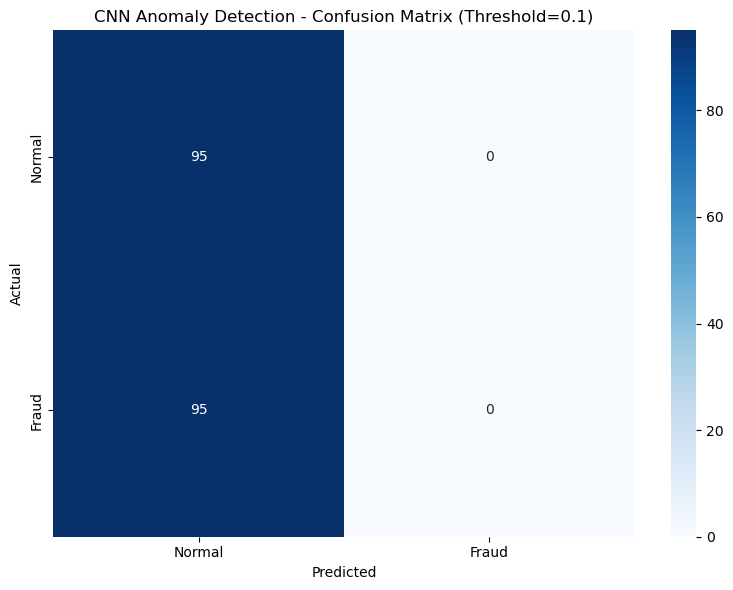

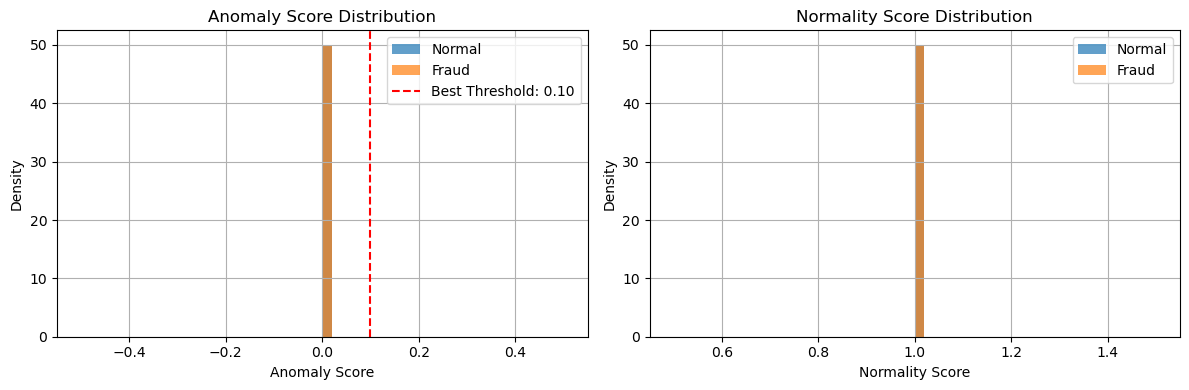

In [9]:
# 혼동 행렬 시각화
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    혼동 행렬을 시각화하는 함수
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        labels: 레이블 이름 리스트
        title: 그래프 제목
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels if labels else ['Normal', 'Fraud'],
                yticklabels=labels if labels else ['Normal', 'Fraud'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# 최적의 임계값으로 예측 및 혼동 행렬 시각화
if 'error' not in results['cnn'] and 'evaluation' in results['cnn']:
    best_threshold = results['cnn']['evaluation']['best_threshold']
    anomaly_scores = results['cnn']['evaluation']['anomaly_scores']
    y_pred = (anomaly_scores >= best_threshold).astype(int)
    
    plot_confusion_matrix(y_test, y_pred, title=f"CNN Anomaly Detection - Confusion Matrix (Threshold={best_threshold:.1f})")
    
    # 추가: 이상치 점수 분포 시각화
    plt.figure(figsize=(12, 4))
    
    # 정상 거래와 사기 거래의 이상치 점수 분포
    plt.subplot(1, 2, 1)
    plt.hist(anomaly_scores[y_test == 0], bins=50, alpha=0.7, label='Normal', density=True)
    plt.hist(anomaly_scores[y_test == 1], bins=50, alpha=0.7, label='Fraud', density=True)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.title('Anomaly Score Distribution')
    plt.legend()
    plt.grid(True)
    
    # 정상도 점수 분포 (원래 모델 출력)
    plt.subplot(1, 2, 2)
    normality_scores = 1 - anomaly_scores
    plt.hist(normality_scores[y_test == 0], bins=50, alpha=0.7, label='Normal', density=True)
    plt.hist(normality_scores[y_test == 1], bins=50, alpha=0.7, label='Fraud', density=True)
    plt.xlabel('Normality Score')
    plt.ylabel('Density')
    plt.title('Normality Score Distribution')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()